# Table of Contents

- [Introduction](#Introduction)
- [Imports](#Imports)
- [Functions](#Functions)
    - [Reading Files](#Reading-Files)
    - [Get Data Statistics](#Get-Data-Statistics)
    - [Image Processing](#Image-Processing)
    - [Model Generation](#Model-Generation)
    - [Visualization](#Visualization)
- [Parameters](#Parameters)
- [Main](#Main)
    - [Reading and clean the stack](#Reading-and-clean-the-stack)
        - [MRI Raw](#MRI-Raw)
        - [Stack Generation](#Stack-Generation)    

# Introduction

This memo explores the various techniques of threshold segmentation and post processing techniques such as opening and closing to obtain the segmented brain.  This document also generated 4 STL files one for each of the most salient aspects of the model.

1. White Matter
2. Gray Matter
3. Tumor Component 1 - this is the outer layer of the tumor
4. Tumor Component 2 - this is the inner layer of the tumor


# Imports

In [1]:
import os
import numpy
import SimpleITK

import scipy.ndimage
import scipy.misc
import scipy.misc as scioM

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from os import listdir
from os.path import isfile, join

In [38]:
from skimage import measure
from skimage import transform
import skimage as skImg
from skimage import morphology
from skimage import filters
from skimage import color, io, img_as_float
# for this module the stl is now depricated
# pip install numpy-stl
from stl import mesh
import imageio

# Functions

## Reading Files

In [4]:
def readMRIFile(inpath):
    # Read an MR file (.dcm,.nii,.mnc) and stores it in an ITK image stack file tensor
    
    reader = SimpleITK.ImageFileReader()
    mriImage = SimpleITK.ReadImage(inpath)
    return mriImage

In [5]:
def convertToNP(itkImage):
    # Converts the a single ITK image into a numpy array
    
    npArray = SimpleITK.GetArrayFromImage(itkImage)
    return npArray    

In [6]:
def applySmoothingMRI(singleMRIImage):
    # Applys smoothing to an ITK image and returns an ITK image
    
    mriImageSmooth = SimpleITK.CurvatureFlow(image1=singleMRIImage,
                                            timeStep=0.125,
                                            numberOfIterations=5)   
    return mriImageSmooth

In [7]:
def readStackOfImage(imageStackDirectory):
    # Get all file names in the firectory 
    onlyFiles = [f for f in listdir(imageStackDirectory) if isfile(join(imageStackDirectory, f))]
    
    # get sizes of each image
    oneFile = imageStackDirectory + onlyFiles[0]
    oneFileImage = scipy.ndimage.imread(oneFile)
    [w,h] = oneFileImage.shape
    
    # Allocate variable for the image stack
    numSlices = len(onlyFiles)
    imageStack = np.zeros((w,h,numSlices))
    
    # Read and store image stack in an array
    for sliceImageFile in onlyFiles:
        imageStack[:,:,sliceInd] = scipy.ndimage.imread(sliceImageFile)
    
    return imageStack

## Get Data Statistics

In [8]:
def getDataStatistics(npArray):
    [numSlices,width,height] = npArray.shape
    print("The data contains {} slices with the image resolution being {} x {}".format(numSlices,width,height))
    
    return [numSlices,width,height]

## Image Processing

In [9]:
def showSegmentation(sliceNum=90):
    # Get slice
    idxSlice = sliceNum
    imgOriginal = image[:,:,idxSlice]

    # Apply smoothing
    imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                        timeStep=0.125,
                                        numberOfIterations=5)
    sitk_show(imgSmooth)

    # Get segmentation
    lstSeeds = [(75,60)]

    imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                                  seedList=lstSeeds, 
                                                  lower=0, 
                                                  upper=40,
                                                  replaceValue=labelWhiteMatter)

    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

    # show segmentation
    sitk_show(imgWhiteMatter)

In [10]:
def getMask(sliceImage,pxlRanges):
#     sliceImage = np.copy(grayMatterMask[:,:,50])
    xLen,yLen = np.shape(sliceImage)
#     pxlRanges = grayMatterRange

    sizeRange = len(pxlRanges)
    
    if(sizeRange==1):
        sliceImage = np.round(sliceImage).astype(int)
        for x in xrange(xLen):
            for y in xrange(yLen):        
                if(sliceImage[x,y] == pxlRanges[0]):                        
                    sliceImage[x,y] = 1.0
                else:
                    sliceImage[x,y] = 0.0        
    else:
        lower = pxlRanges[0]
        upper = pxlRanges[1]

        for x in xrange(xLen):
            for y in xrange(yLen):        
                if(sliceImage[x,y]>=lower and sliceImage[x,y]<=upper):                        
                    sliceImage[x,y] = 1.0
                else:
                    sliceImage[x,y] = 0.0
    
    return sliceImage

In [11]:
def applyMorphFilters(img,erodeFilter,dilationFilter):
    eroded = morphology.erosion(img,np.ones(erodeFilter))
    dilation = morphology.dilation(eroded,np.ones(dilationFilter))    
    return dilation

## Model Generation

In [12]:
def make_mesh(image, threshold=-100, step_size=1):
    # Generates a mesh from a stack of images (image variable)
    
    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    try:
        verts, faces = measure.marching_cubes(p, threshold) 
    except:
        verts, faces = measure.marching_cubes_classic(p, threshold)         
    return verts, faces

In [13]:
def make_meshNew(image, threshold=-100, step_size=1):
    # Generates a mesh from a stack of images (image variable)
    
    print "Transposing surface"
#     p = image.transpose(2,1,0)
    p=image
    
    print "Calculating surface"
    try:
        if(threshold==0.0):
            verts, faces = measure.marching_cubes(p) 
        else:            
            verts, faces = measure.marching_cubes(p, threshold) 
    except:
        if(threshold==0.0):
            verts, faces = measure.marching_cubes_classic(p)         
        else:
            verts, faces = measure.marching_cubes_classic(p, threshold)         
    return verts, faces

In [14]:
def generateSTL(fileOut,imageStack,TH=0.0):
    # Note: imageStack is the output of the function readStackOfImage
    
    # Get verticies
    v, f = make_meshNew(imageStack,TH)
    
    # Generate mesh
    imageMesh = mesh.Mesh(np.zeros(f.shape[0], dtype=mesh.Mesh.dtype))
    
    # Connect Vertices
    for i, f in enumerate(f):
        for j in range(3):
            imageMesh.vectors[i][j] = v[f[j],:]
        
    # Create Mesh    
    imageMesh.save(fileOut)    

In [15]:
def generateImageStack(imageStack,outFileDir,viewType='axial'): 
    # ----------------------------------------------------------------------------
    # imageStack = is a np array with the format [slice,width,height]
    # outFileDir = location where all the images will be saved    
    # ----------------------------------------------------------------------------   
    
    [depth,width,height] = imageStack.shape
    
    if(viewType=='axial'):
        numSlices =  depth
    elif(viewType=='coronal'):
        numSlices =  width
    elif(viewType=='sagittal'):
        numSlices =  height
    
    for sliceInd in xrange(numSlices):
        saveImg = getPlanarViewImage(imageStack,sliceInd,viewType=viewType)
        scioM.imsave(outFileDir + '{}.jpg'.format(sliceInd), saveImg)
    
    print('Create the image stack in the folder {}'.format(outFileDir))

## Visualization

In [16]:
def showTHData(imgStack,sliceInd,th):
    # get a slice    
    [numSlices,width,height] = imgStack.shape
    imgStackSlice = imgStack[sliceInd,:,:].astype(int)

    # Threshold slices
    sliceColourCode = np.zeros([len(th),width,height])

    for thInd in xrange(len(th)):
        for w in xrange(width):
            for h in xrange(height):            
                if imgStackSlice[w,h] != th[thInd]:
                    sliceColourCode[thInd,w,h] = 0
                else:
                    sliceColourCode[thInd,w,h] = th[thInd]

    #Plot TH slices
    figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    for thInd in xrange(len(th)):
        plt.subplot(1,len(th)+1,thInd+1)        
        plt.imshow(sliceColourCode[thInd,:,:])
        plt.title('TH = {}'.format(thInd+1))   

    plt.subplot(1,len(th)+1,len(th)+1)        
    plt.imshow(imgStackSlice)

    plt.tight_layout()
    plt.show()    

In [17]:
def plotHistogram(imageStack,indSlice,viewType='axial',cmap='bone'):
    
    mrImg1 = getPlanarViewImage(imageStack,indSlice,viewType=viewType)
    
    # show second slice
    uniqueBins = (np.unique(mrImg1.astype(int).ravel()))
    
    # show first slice
    plt.subplot(1,2,1)    
    plt.set_cmap(cmap)        
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(indSlice))
    
    # show second slice    
    plt.subplot(1,2,2)      
    plt.hist(mrImg1.ravel(),len(uniqueBins),[0,len(uniqueBins)]); 
    plt.title('Histogram')
    
    plt.show()

In [18]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    # Simple visualization tool to view a single slice
    
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [19]:
def resizePlane(mrSlice,w,h):   
    # ----------------------------------------------------------------------------
    # resizedMRImage = image (np array) you want to resize
    # w = value of width
    # h = value of height
    # ----------------------------------------------------------------------------
    resizedMRImage = transform.resize(mrSlice,(w,h),anti_aliasing =True)
    return resizedMRImage

In [20]:
def getPlanarViewImage(imgStack,indSlice,viewType='axial'):
    # ----------------------------------------------------------------------------
    # imageStack = is a np array with the format [slice,width,height]
    # indSlice = the index of the slice you want to view
    # viewType = string specifying planar views, can be 'axial', 'coronal', 'sagittal'     
    # ----------------------------------------------------------------------------
    [numSlices,width,height] = imgStack.shape    
    
    if(viewType=='axial'):
        mrImage =  imgStack[indSlice,:,:]    
    elif(viewType=='coronal'):
        mrImage =  np.flipud(imgStack[:,indSlice,:])
        mrImage = resizePlane(mrImage,width,height)        
    elif(viewType=='sagittal'):
        mrImage =  np.flipud(np.fliplr(imgStack[:,:,indSlice]))
        mrImage = resizePlane(mrImage,width,height)        
    
    return mrImage    

In [21]:
def showTHMorphFiltering(imgStack,sliceInd,erodeFilter,dilationFilter,th):
    # -
    # imgStack = mr image stack in the form of  [slice, w,h]
    # sliceInd = slice index
    # erodeFilter = 2x2 array ex [1,1]
    # dilationFilter = 2x2 array ex [2,2]
    # th = a single digit array ex [1]
    # ------
    # get a random slice    
    mrSliceSeg = imgStack[sliceInd,:,:]

    # get a mask from a threshold    
    mrSliceTH = getMask(mrSliceSeg,th)

    # apply the morphological filters    
    morphImage = applyMorphFilters(mrSliceTH,erodeFilter,dilationFilter)

    # shoe the two side by side
    plt.figure()
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,3,1)
    plt.imshow(mrSliceSeg)
    plt.title('Unprocessed data')
    plt.subplot(1,3,2)
    plt.imshow(mrSliceTH)
    plt.title('Thresholded image')
    plt.subplot(1,3,3)
    plt.imshow(morphImage)
    plt.title('Morphological filters applied')
    plt.tight_layout()
    plt.show()    

In [22]:
def display3Slices(imageStack,arrayIndSlice,viewType='axial',cmap="bone"):
    # ----------------------------------------------------------------------------
    # imageStack = is a np array with the format [slice,width,height]
    # arrayIndSlice = is a an array with 3 ind values no greater than max slice,max width or max height
    # viewType = string specifying planar views, can be 'axial', 'coronal', 'sagittal' 
    # cmap = the most commonly used ones are ["gray",'bone','binary','jet', 'gist_ncar','seismic','Set1',]
    # ----------------------------------------------------------------------------
    [numSlices,width,height] = imageStack.shape
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    
    # show first slice
    plt.subplot(1,3,1)    
    plt.set_cmap(cmap)    
    mrImg1 = getPlanarViewImage(imageStack,arrayIndSlice[0],viewType=viewType)
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[0]))
    
    # show second slice
    plt.subplot(1,3,2)    
    plt.set_cmap(cmap)    
    mrImg1 = getPlanarViewImage(imageStack,arrayIndSlice[1],viewType=viewType)
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[1]))
    
    # show third slice
    plt.subplot(1,3,3)    
    plt.set_cmap(cmap)    
    mrImg1 = getPlanarViewImage(imageStack,arrayIndSlice[2],viewType=viewType)
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[2]))
    
    plt.tight_layout()
    plt.show()

![planarViews](https://faculty.washington.edu/chudler/gif/slice.gif)

In [23]:
def getMaskedColouredMRSlice(mrSlice,labelSlice,TH,colourCode,alpha):
    # ----------------------------------------------------------------------------
    # Applys colour convention based on label
    # labelSlice = labels of the segmentation
    # mrSlice =  original MR data    
    # colourCode = array which contains the RGB colours for the white,gray,TC1 and TC2
    # TH = array which contains the TH colours for the white,gray,TC1 and TC2
    # alpha = alpha value to be overlayed
    # ----------------------------------------------------------------------------

    #Colour mapping
    whiteMatterColour = colourCode[0]
    grayMatterColour = colourCode[1]
    tc1MatterColour = colourCode[2]
    tc2MatterColour = colourCode[3]
    
    imgSlice = np.round(labelSlice).astype(int)
    
    # get the image
    if(mrSlice.max()==0):
        mrSlice = mrSlice/0.000001
    else:
        mrSlice = mrSlice/mrSlice.max()

    # Generate mask
    rows, cols = imgSlice.shape
    color_mask = np.zeros((rows, cols, 3))

    for r in xrange(rows):
        for c in xrange(cols):         
            if(imgSlice[r,c]==TH[0]):    
                [rChannel, gChannel, bChannel] =  whiteMatterColour
            elif(imgSlice[r,c]==TH[1]):    
                [rChannel, gChannel, bChannel] =  grayMatterColour        
            elif(imgSlice[r,c]==TH[2]):    
                [rChannel, gChannel, bChannel] =  tc1MatterColour
            elif(imgSlice[r,c]==TH[3]):    
                [rChannel, gChannel, bChannel] =  tc2MatterColour
            else:
                [rChannel, gChannel, bChannel] =  [0.0,0.0,0.0]
            color_mask[r,c] = [rChannel, gChannel, bChannel]  

    # Construct RGB version of grey-level image
    img_color = np.dstack((mrSlice, mrSlice, mrSlice))

    # Apply mask
    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    
    return img_masked

In [24]:
def display3SlicesWithMask(labelStack,mrStack,arrayIndSlice,TH,colourCode,alpha,viewType='axial'):
    # ----------------------------------------------------------------------------
    # Displays the overlay of colours over the desired segmented area
    # labelStack = is a np array with the format [slice,width,height] which corresponds to labels
    # labelStack = is a np array with the format [slice,width,height] which is the original MR data
    # arrayIndSlice = is a an array with 3 ind values no greater than max slice,max width or max height
    # viewType = string specifying planar views, can be 'axial', 'coronal', 'sagittal' 
    # colourCode = array which contains the RGB colours for the white,gray,TC1 and TC2
    # TH = array which contains the TH colours for the white,gray,TC1 and TC2
    # alpha = alpha value to be overlayed
    # ----------------------------------------------------------------------------
    [numSlices,width,height] = labelStack.shape
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    
    # show first slice
    plt.subplot(1,3,1)           
    mrImg1 = getPlanarViewImage(mrStack,arrayIndSlice[0],viewType=viewType)
    mrImgLabel1 = getPlanarViewImage(labelStack,arrayIndSlice[0],viewType=viewType)
    maskedImg1 = getMaskedColouredMRSlice(mrImg1,mrImgLabel1,TH,colourCode,alpha)
    plt.imshow(maskedImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[0]))
    
    # show second slice
    plt.subplot(1,3,2)        
    mrImg2 = getPlanarViewImage(mrStack,arrayIndSlice[1],viewType=viewType)
    mrImgLabel2 = getPlanarViewImage(labelStack,arrayIndSlice[1],viewType=viewType)
    maskedImg2 = getMaskedColouredMRSlice(mrImg2,mrImgLabel2,TH,colourCode,alpha)
    plt.imshow(maskedImg2)    
    plt.title('Showing Slice {}'.format(arrayIndSlice[1]))
    
    # show third slice
    plt.subplot(1,3,3)        
    mrImg3 = getPlanarViewImage(mrStack,arrayIndSlice[2],viewType=viewType)
    mrImgLabel3 = getPlanarViewImage(labelStack,arrayIndSlice[2],viewType=viewType)
    maskedImg3 = getMaskedColouredMRSlice(mrImg3,mrImgLabel3,TH,colourCode,alpha)
    plt.imshow(maskedImg3)  
    plt.title('Showing Slice {}'.format(arrayIndSlice[2]))
    
    plt.tight_layout()
    plt.show()

# Parameters

In [25]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//human//githubDrRueda-ToicenCourse//t2.dcm'

In [26]:
inpathTruth = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//human//githubDrRueda-ToicenCourse//truth.dcm'

# Main

## Reading and clean the stack

### MRI Raw

In [27]:
mriStack = readMRIFile(inpath)

In [28]:
mriStackSmooth = applySmoothingMRI(mriStack)

In [29]:
mriData = convertToNP(mriStackSmooth)

In [30]:
[numSlices,width,height] = getDataStatistics(mriData)

The data contains 181 slices with the image resolution being 256 x 256


### Stack Generation

In [31]:
mriStackSeg = readMRIFile(inpathTruth)

In [32]:
mriStackSmoothSeg = applySmoothingMRI(mriStackSeg)

In [33]:
mriDataSeg = convertToNP(mriStackSmoothSeg)

In [34]:
[numSlicesSeg,widthSeg,heightSeg] = getDataStatistics(mriDataSeg)

The data contains 181 slices with the image resolution being 256 x 256


C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


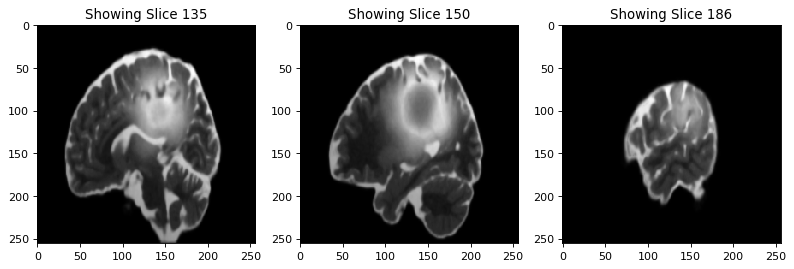

In [35]:
display3Slices(mriData,[height/3+50,height/3*2-20,height-70],viewType='sagittal',cmap="gray")

In [56]:
PathDicom = "C://Cerebral//_MarioSandBox//DB//medicalHolography//imgStacks//Human//sagittalTumor//"
OutFile = PathDicom 

In [ ]:
sliceInd = 10
sliceImg = np.array(mriData[sliceInd,:,:])

In [57]:
for sliceInd in xrange(numSlices):
    sliceImg = np.array( mriData[sliceInd,:,:],dtype='uint8')
    imageio.imwrite(OutFile + '{}.jpg'.format(sliceInd),sliceImg)

In [44]:
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')    
# show first slice
plt.imshow(sliceImg)
plt.axis('off')
plt.savefig(OutFile + '{}.jpg'.format(sliceInd), bbox_inches='tight')

KeyboardInterrupt: 

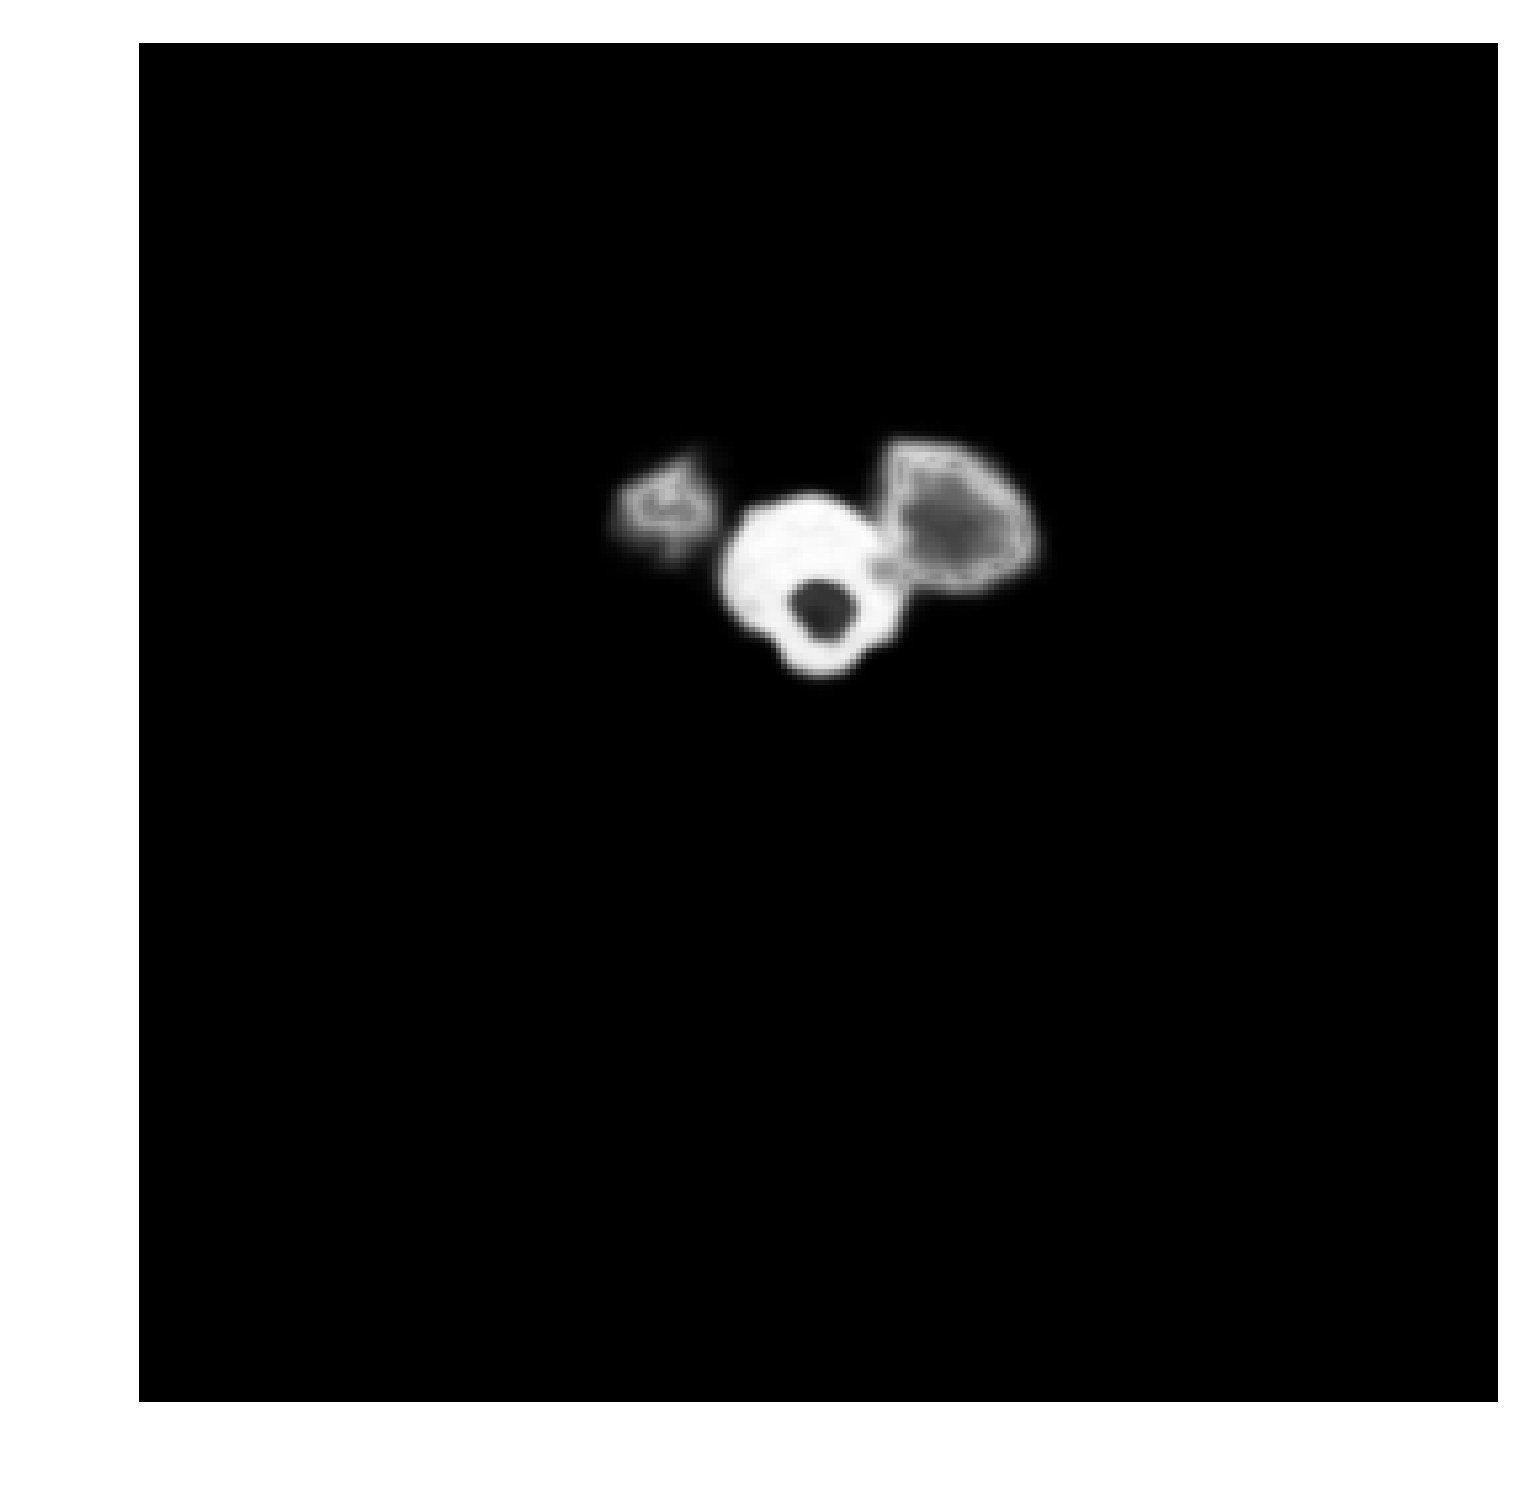

In [69]:
figure(num=None, figsize=(10, 6), dpi=300, facecolor='w', edgecolor='k')    
for sliceInd in xrange(numSlices):
    sliceImg = np.array( mriData[sliceInd,:,:])
    
    plt.imshow(sliceImg)
    plt.axis('off')
    plt.savefig(OutFile + '{}.jpg'.format(sliceInd), bbox_inches='tight')